In [ ]:
!pip install findspark

In [2]:
import findspark
findspark.init()

In [3]:
from pyspark.sql import SparkSession

spark = (
    SparkSession
        .builder
        .appName("HOMEWORK")
        .getOrCreate()
)

In [4]:
!hdfs dfs -ls /user/ubuntu/data
#!hdfs dfs -cat /user/ubuntu/data/2019-08-22.txt | head -n 3

Found 5 items
-rw-r--r--   1 ubuntu hadoop 2807409271 2026-01-29 13:36 /user/ubuntu/data/2019-08-22.txt
-rw-r--r--   1 ubuntu hadoop 2854479008 2026-01-29 13:37 /user/ubuntu/data/2019-09-21.txt
-rw-r--r--   1 ubuntu hadoop 2895460543 2026-01-29 13:38 /user/ubuntu/data/2019-10-21.txt
-rw-r--r--   1 ubuntu hadoop 2939120942 2026-01-29 13:40 /user/ubuntu/data/2019-11-20.txt
-rw-r--r--   1 ubuntu hadoop 2995462277 2026-01-29 13:41 /user/ubuntu/data/2019-12-20.txt


In [5]:
'''
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.types import StructType, StructField, StringType

spark = SparkSession.builder.appName("csv_sep_fix_to_parquet").getOrCreate()

# 1) Жёсткая схема на 9 колонок как у вас
raw_schema = StructType([StructField(f"_c{i}", StringType(), True) for i in range(9)])

src = "hdfs:///user/ubuntu/data/"      # <-- папка с 5 файлами (txt/csv)
dst = "hdfs:///user/ubuntu/parquet/" # <-- куда писать parquet

# 2) Чтение всех файлов как одного датасета
df = (spark.read
      .option("header", "false")
      .option("sep", ",")              # <-- ваш sep
      .option("mode", "PERMISSIVE")
      .schema(raw_schema)
      .csv(src))

# 3) Выкинуть строку-заголовок, если она встречается в данных
bad = "# tranaction_id | tx_datetime | customer_id | terminal_id | tx_amount | tx_time_seconds | tx_time_days | tx_fraud | tx_fraud_scenario"
df = df.filter(F.col("_c0") != bad)

# (часто полезно) ещё защититься от пустых/битых строк:
df = df.filter(F.col("_c0").isNotNull())

# 4) Переименовать колонки
df = df.toDF(
    "transaction_id", "tx_datetime", "customer_id", "terminal_id", "tx_amount",
    "tx_time_seconds", "tx_time_days", "tx_fraud", "tx_fraud_scenario"
)

# 5) (Рекомендуется) привести типы, чтобы Parquet был "правильным"
df = (df
      .withColumn("transaction_id", F.col("transaction_id").cast("long"))
      .withColumn("tx_datetime", F.to_timestamp("tx_datetime", "yyyy-MM-dd HH:mm:ss"))
      .withColumn("customer_id", F.col("customer_id").cast("long"))
      .withColumn("terminal_id", F.col("terminal_id").cast("long"))
      .withColumn("tx_amount", F.col("tx_amount").cast("double"))
      .withColumn("tx_time_seconds", F.col("tx_time_seconds").cast("long"))
      .withColumn("tx_time_days", F.col("tx_time_days").cast("int"))
      .withColumn("tx_fraud", F.col("tx_fraud").cast("int"))
      .withColumn("tx_fraud_scenario", F.col("tx_fraud_scenario").cast("int"))
)

# 6) Запись Parquet (НЕ в один файл)
(df.write
   .mode("overwrite")
   .parquet(dst))
'''


'\nfrom pyspark.sql import SparkSession, functions as F\nfrom pyspark.sql.types import StructType, StructField, StringType\n\nspark = SparkSession.builder.appName("csv_sep_fix_to_parquet").getOrCreate()\n\n# 1) Жёсткая схема на 9 колонок как у вас\nraw_schema = StructType([StructField(f"_c{i}", StringType(), True) for i in range(9)])\n\nsrc = "hdfs:///user/ubuntu/data/"      # <-- папка с 5 файлами (txt/csv)\ndst = "hdfs:///user/ubuntu/parquet/" # <-- куда писать parquet\n\n# 2) Чтение всех файлов как одного датасета\ndf = (spark.read\n      .option("header", "false")\n      .option("sep", ",")              # <-- ваш sep\n      .option("mode", "PERMISSIVE")\n      .schema(raw_schema)\n      .csv(src))\n\n# 3) Выкинуть строку-заголовок, если она встречается в данных\nbad = "# tranaction_id | tx_datetime | customer_id | terminal_id | tx_amount | tx_time_seconds | tx_time_days | tx_fraud | tx_fraud_scenario"\ndf = df.filter(F.col("_c0") != bad)\n\n# (часто полезно) ещё защититься от пусты

In [6]:
df = spark.read.parquet("/user/ubuntu/parquet/",)

In [7]:
df.printSchema()
df.show(5, truncate=False)
df.count()

root
 |-- transaction_id: long (nullable = true)
 |-- tx_datetime: timestamp (nullable = true)
 |-- customer_id: long (nullable = true)
 |-- terminal_id: long (nullable = true)
 |-- tx_amount: double (nullable = true)
 |-- tx_time_seconds: long (nullable = true)
 |-- tx_time_days: integer (nullable = true)
 |-- tx_fraud: integer (nullable = true)
 |-- tx_fraud_scenario: integer (nullable = true)

+--------------+-------------------+-----------+-----------+---------+---------------+------------+--------+-----------------+
|transaction_id|tx_datetime        |customer_id|terminal_id|tx_amount|tx_time_seconds|tx_time_days|tx_fraud|tx_fraud_scenario|
+--------------+-------------------+-----------+-----------+---------+---------------+------------+--------+-----------------+
|13928075      |2019-08-30 09:23:52|894191     |777        |20.75    |725032         |8           |0       |0                |
|13928076      |2019-08-30 08:52:05|894191     |818        |15.48    |723125         |8     

234964612

In [ ]:
from pyspark.sql import functions as F

df.agg(F.countDistinct("customer_id").alias("n_unique_customers")).show()

+------------------+
|n_unique_customers|
+------------------+
|            995156|
+------------------+



In [9]:
(df
    .groupBy("customer_id")
    .agg(F.count("*").alias("n_tx"))
    .orderBy(F.desc("n_tx"))
    .show(10)
)

+-----------+----+
|customer_id|n_tx|
+-----------+----+
|    -999999| 551|
|     766837| 532|
|     262404| 526|
|     916957| 525|
|      13041| 523|
|     836971| 521|
|     621117| 521|
|     861823| 520|
|     424748| 518|
|     957105| 517|
+-----------+----+
only showing top 10 rows



In [35]:
df.select("tx_fraud").distinct().show()

+--------+
|tx_fraud|
+--------+
|       1|
|       0|
+--------+



In [12]:
df.select("tx_fraud_scenario").distinct().show()

+-----------------+
|tx_fraud_scenario|
+-----------------+
|                1|
|                3|
|                2|
|                0|
+-----------------+



In [13]:
(df
 .agg(
     F.min("tx_datetime").alias("min_tx_datetime"),
     F.max("tx_datetime").alias("max_tx_datetime"),
 )
 .show(truncate=False)
)

+-------------------+-------------------+
|min_tx_datetime    |max_tx_datetime    |
+-------------------+-------------------+
|2019-08-22 00:00:00|2020-01-18 23:59:59|
+-------------------+-------------------+



In [33]:
n_days = (df
    .select(F.to_date("tx_datetime").alias("day"))
    .agg(F.countDistinct("day").alias("n_unique_days"))
)
n_days.show()

+-------------+
|n_unique_days|
+-------------+
|          150|
+-------------+



In [28]:
n_null = df.filter(F.col("tx_datetime").isNull()).count()
print(n_null)

490


In [29]:
df = df.filter(F.col("tx_datetime").isNotNull())

In [ ]:
(df
  .select(F.date_trunc("week", F.col("tx_datetime")).cast("date").alias("week_start"))
  .agg(F.countDistinct("week_start").alias("n_weeks"))
  .show()
)

+-------+
|n_weeks|
+-------+
|     22|
+-------+



In [31]:
(df
  .withColumn("week_start", F.date_trunc("week", F.col("tx_datetime")).cast("date"))
  .groupBy("week_start")
  .agg(F.sum(F.col("tx_fraud").cast("int")).alias("n_fraud"))
  .orderBy("week_start")
  .show(25)
)

+----------+-------+
|week_start|n_fraud|
+----------+-------+
|2019-08-19| 342812|
|2019-08-26| 600648|
|2019-09-02| 587343|
|2019-09-09| 590755|
|2019-09-16| 568427|
|2019-09-23| 563446|
|2019-09-30| 549945|
|2019-10-07| 680258|
|2019-10-14| 728023|
|2019-10-21| 736265|
|2019-10-28| 746363|
|2019-11-04| 633446|
|2019-11-11| 596038|
|2019-11-18| 595510|
|2019-11-25| 592204|
|2019-12-02| 581120|
|2019-12-09| 549254|
|2019-12-16| 538397|
|2019-12-23| 545284|
|2019-12-30| 560419|
|2020-01-06| 574533|
|2020-01-13| 486644|
+----------+-------+



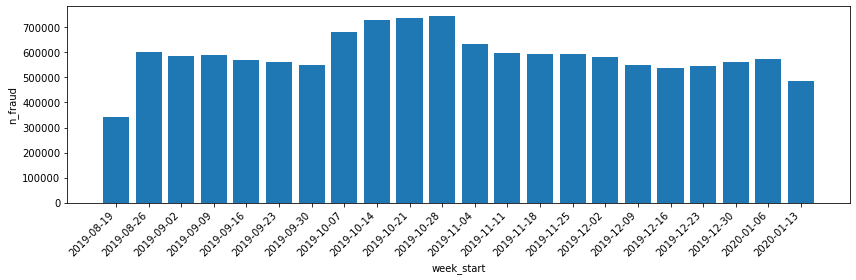

In [32]:
import matplotlib.pyplot as plt

weekly = (df
  .withColumn("week_start", F.date_trunc("week", F.col("tx_datetime")).cast("date"))
  .groupBy("week_start")
  .agg(F.sum(F.col("tx_fraud").cast("int")).alias("n_fraud"))
  .orderBy("week_start")
)

pdf = weekly.toPandas()  # недель мало — обычно ок

plt.figure(figsize=(12, 4))
plt.bar(pdf["week_start"].astype(str), pdf["n_fraud"])
plt.xticks(rotation=45, ha="right")
plt.xlabel("week_start")
plt.ylabel("n_fraud")
plt.tight_layout()
plt.show()